In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots/cnn_cor/'
modelpath = path_prefix+'classifier/Models/'

In [3]:
# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

In [4]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [5]:
inputpath = path_prefix+'inputs/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [6]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [7]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [8]:
import tensorflow as tf

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [9]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [10]:
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [11]:
model = tf.keras.models.load_model(modelpath+"model_p1_d02.h5")

In [12]:
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 4), layers=['EMB1']),last=True)
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16), layers=['EMB2', 'EMB3']),last=True)
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [13]:
cnn_scores = model.predict(
    [pcellsE1_EMB1G_channels[pdata_merged.test],
     pcellsE23_EMB2G_channels[pdata_merged.test],
     pcellsT123_T1G_channels[pdata_merged.test]])

In [48]:
# calculate inclusive correlations
import scipy
input_layers = {
    "E1": pcellsE1_EMB1G_channels,
    "E23": pcellsE23_EMB2G_channels,
    "T123": pcellsT123_T1G_channels,
}
cor = {}
for ptype, pindex in {'pi0':0, 'piplus':1}.items():
    cor[ptype] = {}
    for layer in mu.cell_meta:
        cell_data = pcells_merged_reshaped[layer][pdata_merged.test][(plabels[pdata_merged.test]==pindex)[:,0]][:,0]
        cor[ptype][layer] = np.zeros(shape=(
            cell_data.shape[1],cell_data.shape[2],2))
        for i in range(cor[ptype][layer].shape[0]):
            for j in range(cor[ptype][layer].shape[1]):
                cor[ptype][layer][i][j] = scipy.stats.pearsonr(
                    cell_data[:,i,j],
                    cnn_scores[(plabels[pdata_merged.test]==pindex)[:,0]][:,0]
            )

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [51]:
# colourmap generator
def get_cmap(xmin,xmax):
    if(xmin > 0):
        # all positive
        cdict = {
            'red': ((0, 1, 1),
                   (1, 0, 0)),
            'green': ((0, 1, 1),
                      (1, 0, 0)),
            'blue': ((0, 1, 1),
                     (1, 1, 1))
        }
    elif(xmax < 0):
        # all negative
        cdict = {
            'red': ((0, 1, 1),
                    (1, 1, 1)),
            'green': ((0, 0, 0),
                     (1, 1, 1)),
            'blue': ((0, 0, 0),
                     (1, 1, 1))
        }
    else:
        # two-sided
        xrange = xmax - xmin
        white_point = -xmin/xrange
        
        cdict = {
            'red': ((0.0, 1.0, 1.0),
                    (white_point, 1.0, 1.0),
                    (1.0, 0.0, 0.0)),
         
            'green': ((0.0, 0.0, 0.0),
                      (white_point, 1.0, 1.0),
                      (1.0, 0.0, 0.0)),
             
            'blue': ((0.0, 0.0, 0.0),
                     (white_point, 1.0, 1.0),
                     (1.0, 1.0, 1.0)),
        }
    return mpl.colors.LinearSegmentedColormap('rwb', cdict, 1024)

<Figure size 576x432 with 0 Axes>

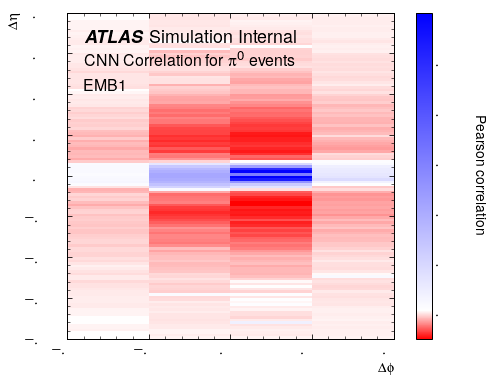

<Figure size 576x432 with 0 Axes>

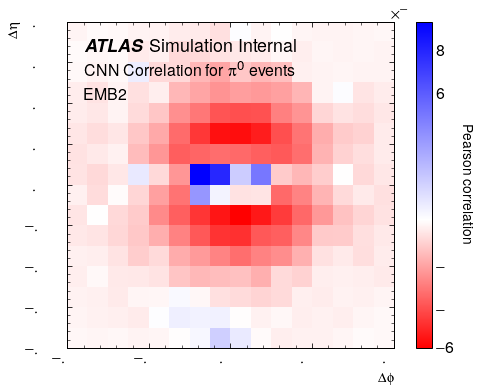

<Figure size 576x432 with 0 Axes>

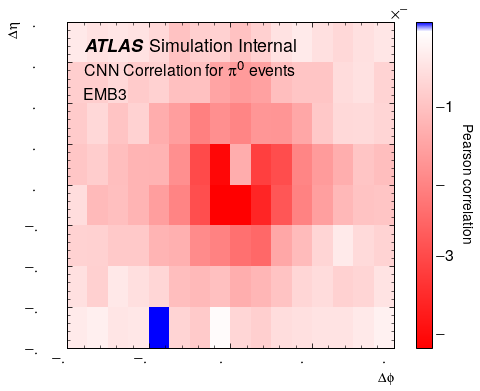

<Figure size 576x432 with 0 Axes>

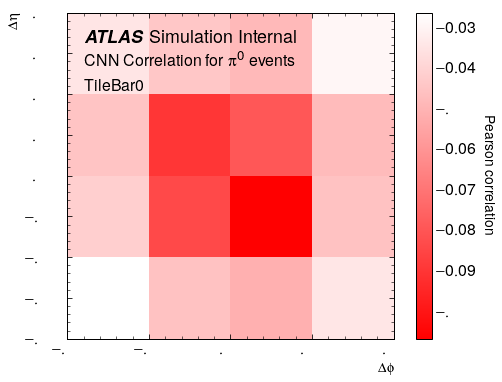

<Figure size 576x432 with 0 Axes>

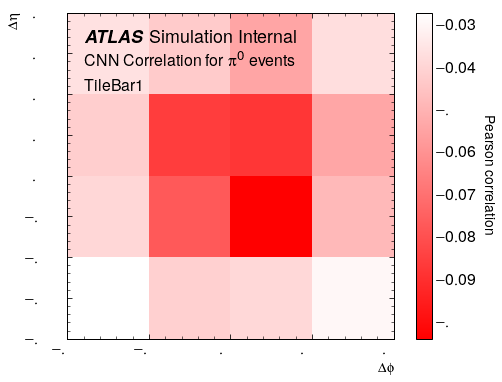

<Figure size 576x432 with 0 Axes>

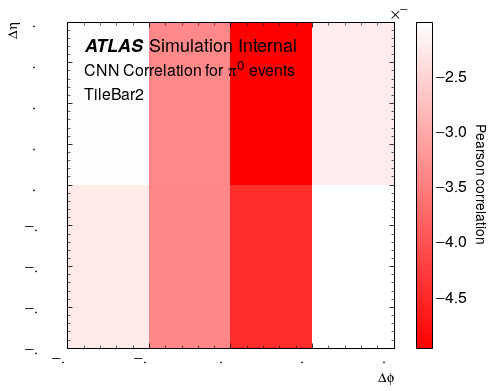

<Figure size 576x432 with 0 Axes>

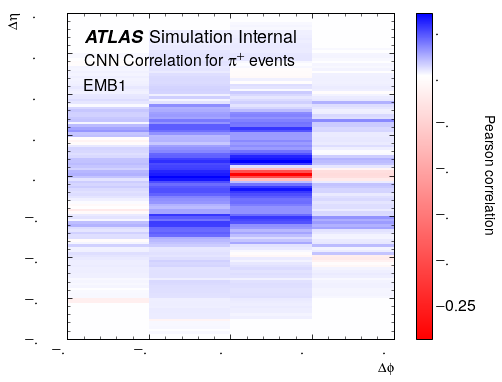

<Figure size 576x432 with 0 Axes>

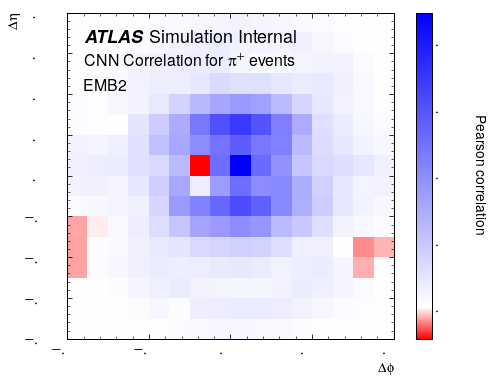

<Figure size 576x432 with 0 Axes>

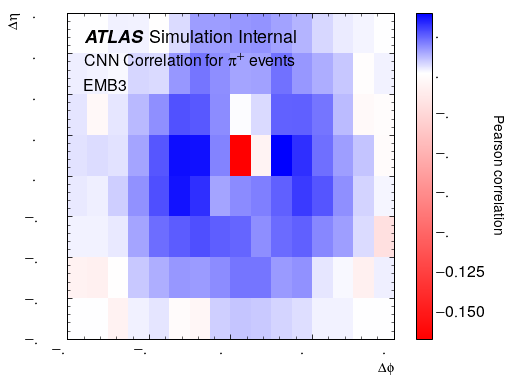

<Figure size 576x432 with 0 Axes>

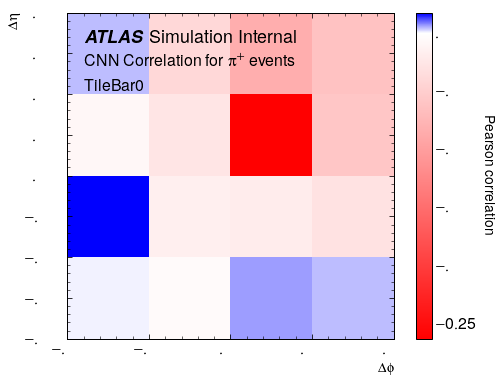

<Figure size 576x432 with 0 Axes>

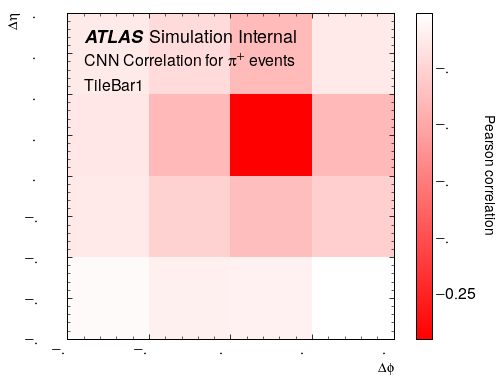

<Figure size 576x432 with 0 Axes>

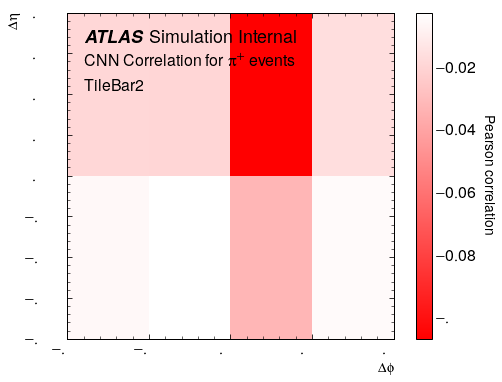

In [54]:
for ptype in cor:
    for layer in mu.cell_meta:
        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        data = cor[ptype][layer][:,:,0]
        data[np.isnan(data)] = 0
        
        xmin = np.amin(data)
        xmax = np.amax(data)
        plt.imshow(data, extent=[-0.2, 0.2, -0.2, 0.2],
                    cmap=get_cmap(xmin,xmax), origin='lower',
                    interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'CNN Correlation for '+pi_latex[ptype]+' events')
        fig.axes[0].text(-0.18, 0.105, layer)
        cbar = plt.colorbar()
        cbar.set_label('Pearson correlation', rotation=270, labelpad=20)
        plt.savefig(plotpath+'cnncor_'+ptype+'_'+layer+'.pdf')
        plt.show()

In [76]:
# calculate energy binned correlations
import scipy
energy_bins = [0, 1, 5, 20, 100, 500]
cor_binned = {}

for ptype, pindex in {'pi0':0, 'piplus':1}.items():
    cor_binned[ptype] = {}
    data = pdata_merged[pdata_merged.test][(plabels[pdata_merged.test]==pindex)[:,0]]
    for layer in mu.cell_meta:
        cor_binned[ptype][layer] = []
        cell_data = pcells_merged_reshaped[layer][pdata_merged.test][(plabels[pdata_merged.test]==pindex)[:,0]][:,0]
        for ibin in range(len(energy_bins)):
            if( ibin == len(energy_bins)-1 ):
                sel = data['clusterE'] > energy_bins[ibin]
                label = 'Energy / GeV > '+str(energy_bins[ibin])
            else:        
                sel = (data['clusterE'] > energy_bins[ibin]) & (data['clusterE'] > energy_bins[ibin+1])
                label = str(energy_bins[ibin])+' < Energy / GeV < '+str(energy_bins[ibin+1])
                
            cell_data_binned = cell_data[sel]

            cor_binned[ptype][layer].append(np.zeros(shape=(
                cell_data_binned.shape[1],cell_data_binned.shape[2],2)))
            for i in range(cor_binned[ptype][layer][ibin].shape[0]):
                for j in range(cor_binned[ptype][layer][ibin].shape[1]):
                    cor_binned[ptype][layer][ibin][i,j] = scipy.stats.pearsonr(
                        cell_data_binned[:,i,j],
                        cnn_scores[(plabels[pdata_merged.test]==pindex)[:,0]][sel][:,0]
                )

0


c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


<Figure size 576x432 with 0 Axes>

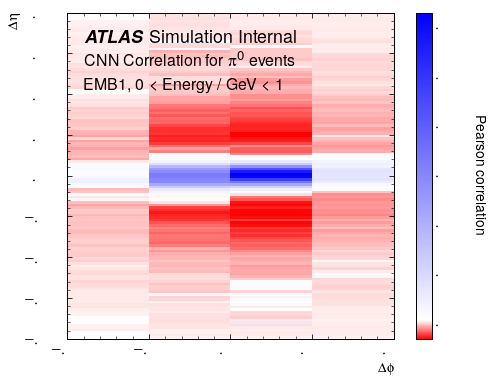

<Figure size 576x432 with 0 Axes>

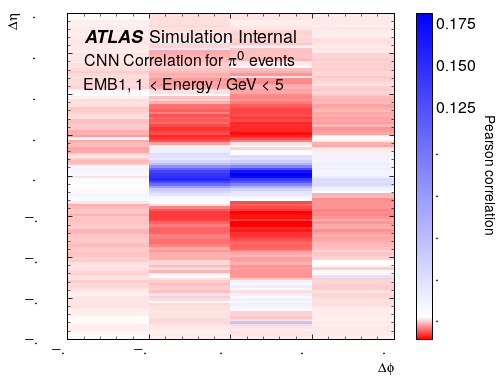

<Figure size 576x432 with 0 Axes>

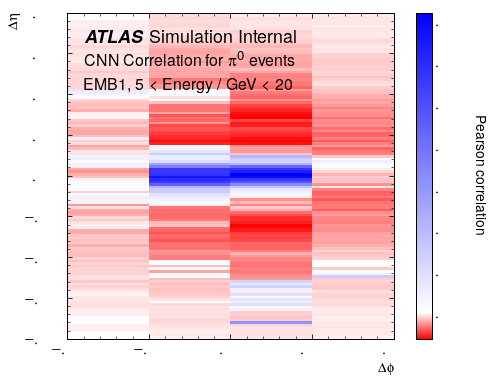

<Figure size 576x432 with 0 Axes>

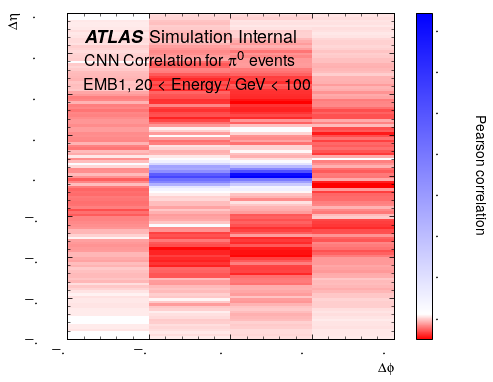

<Figure size 576x432 with 0 Axes>

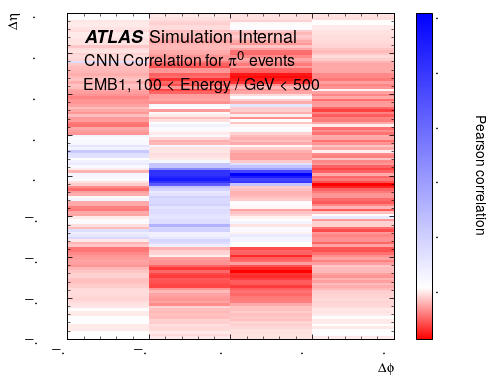

<Figure size 576x432 with 0 Axes>

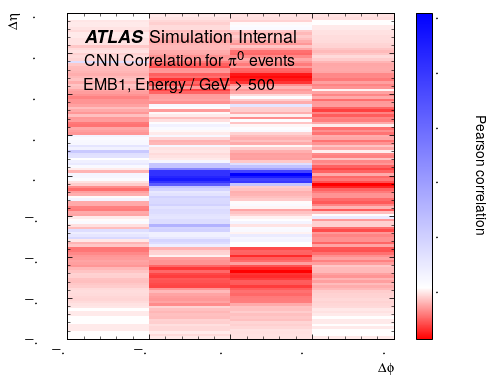

<Figure size 576x432 with 0 Axes>

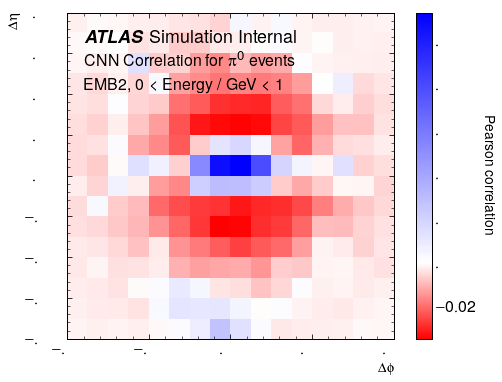

<Figure size 576x432 with 0 Axes>

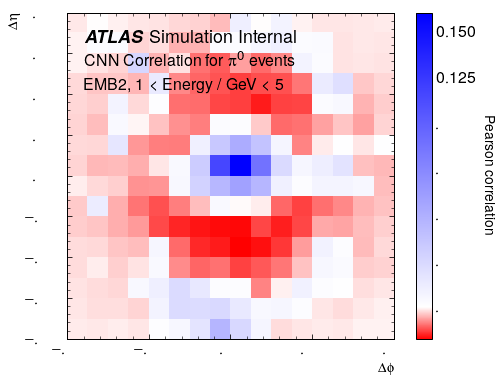

<Figure size 576x432 with 0 Axes>

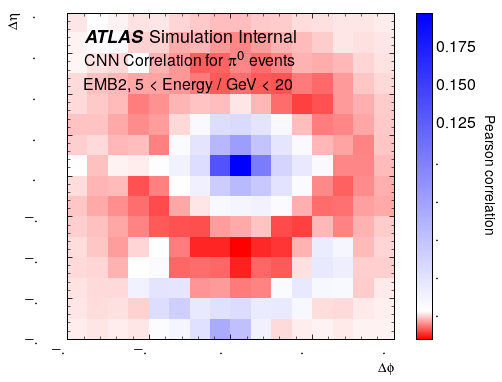

<Figure size 576x432 with 0 Axes>

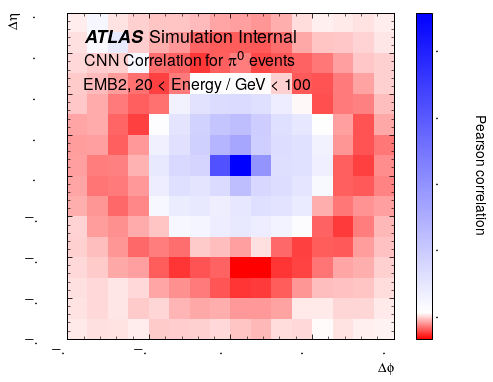

<Figure size 576x432 with 0 Axes>

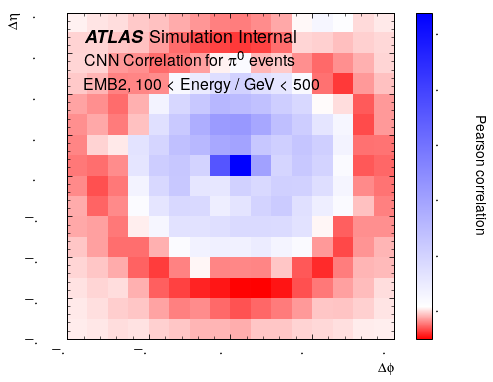

<Figure size 576x432 with 0 Axes>

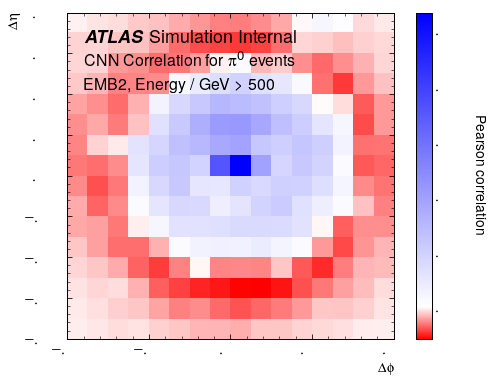

<Figure size 576x432 with 0 Axes>

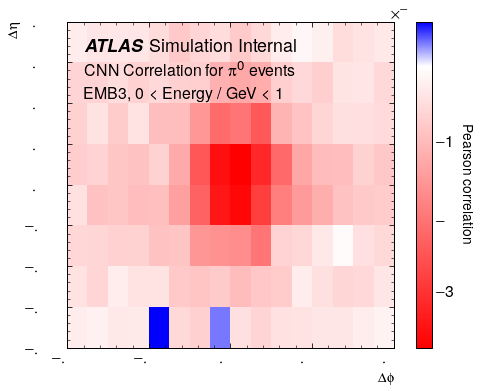

<Figure size 576x432 with 0 Axes>

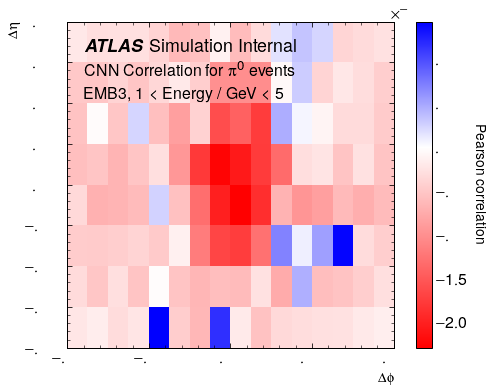

<Figure size 576x432 with 0 Axes>

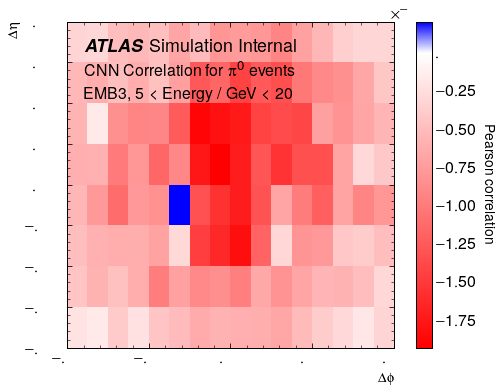

<Figure size 576x432 with 0 Axes>

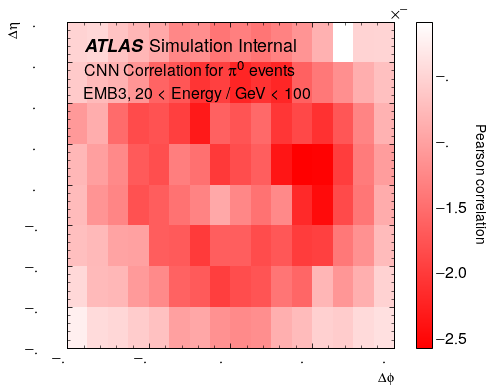

<Figure size 576x432 with 0 Axes>

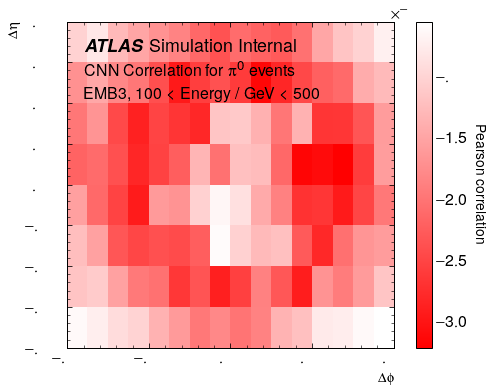

<Figure size 576x432 with 0 Axes>

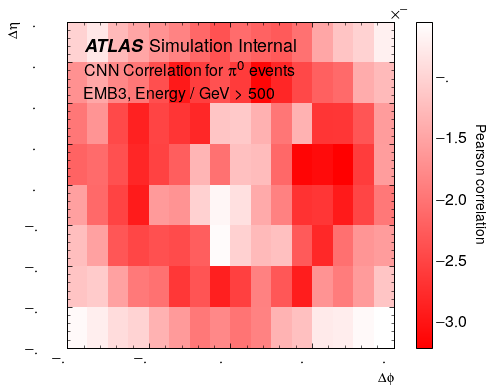

<Figure size 576x432 with 0 Axes>

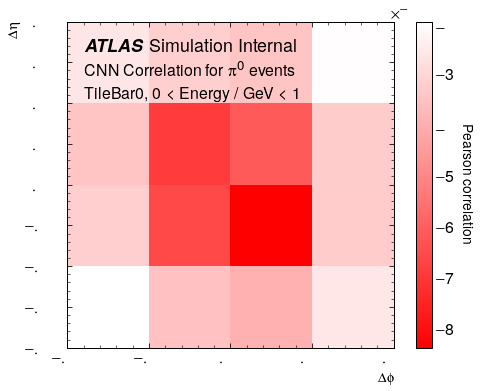

<Figure size 576x432 with 0 Axes>

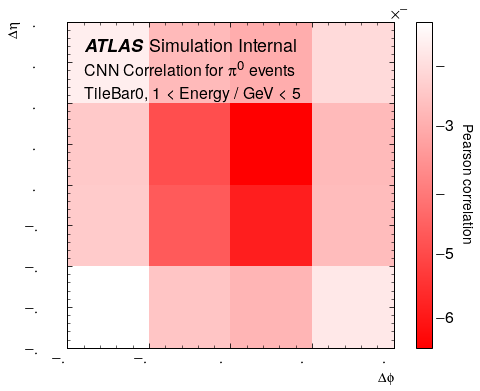

<Figure size 576x432 with 0 Axes>

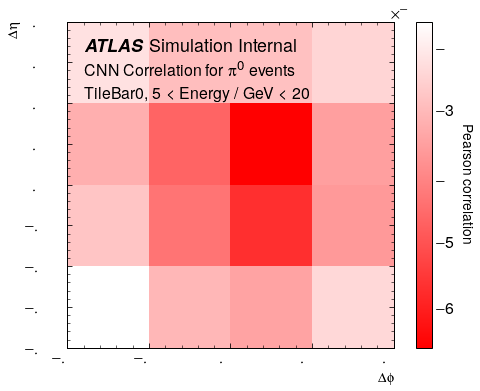

<Figure size 576x432 with 0 Axes>

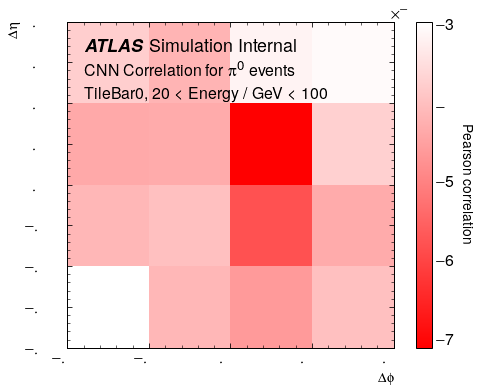

<Figure size 576x432 with 0 Axes>

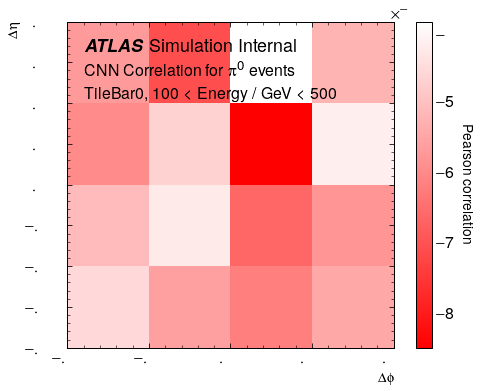

<Figure size 576x432 with 0 Axes>

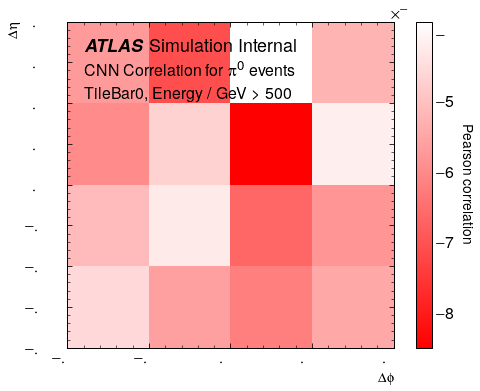

<Figure size 576x432 with 0 Axes>

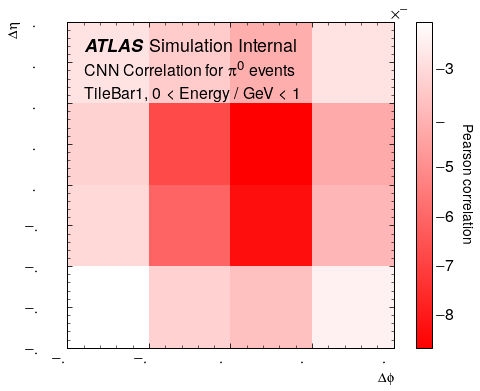

<Figure size 576x432 with 0 Axes>

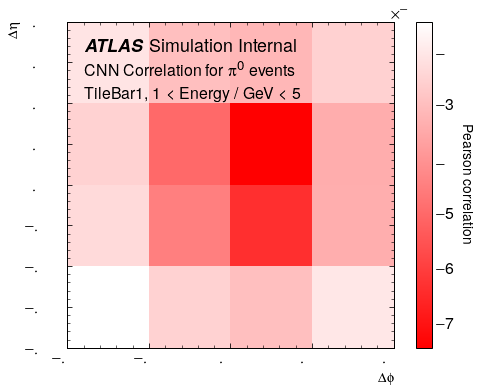

<Figure size 576x432 with 0 Axes>

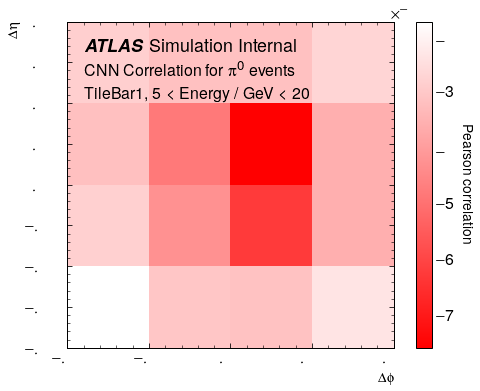

<Figure size 576x432 with 0 Axes>

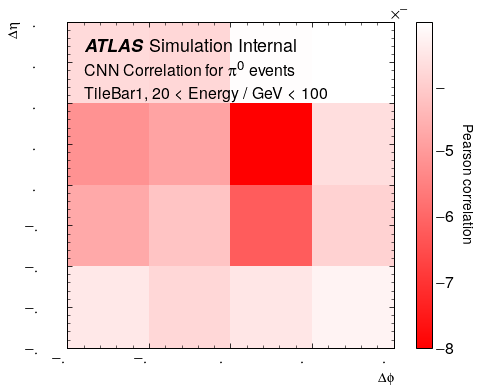

<Figure size 576x432 with 0 Axes>

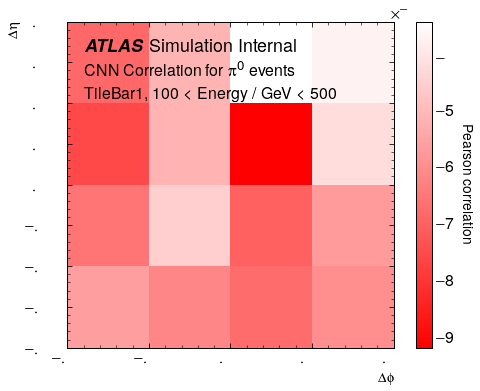

<Figure size 576x432 with 0 Axes>

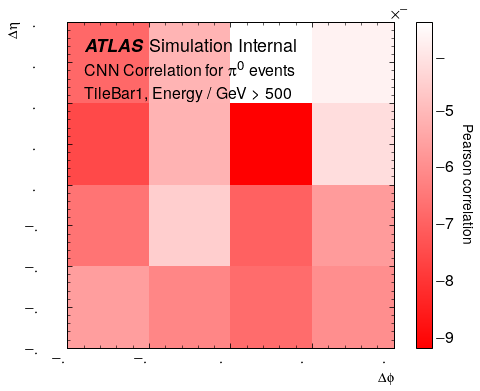

<Figure size 576x432 with 0 Axes>

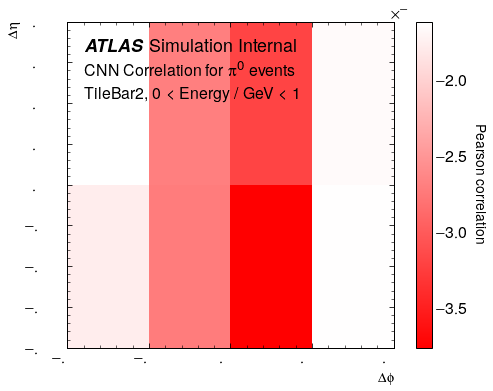

<Figure size 576x432 with 0 Axes>

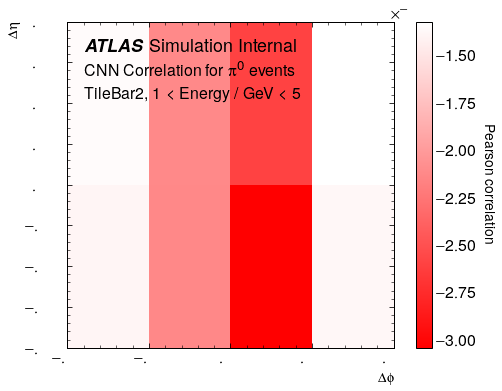

<Figure size 576x432 with 0 Axes>

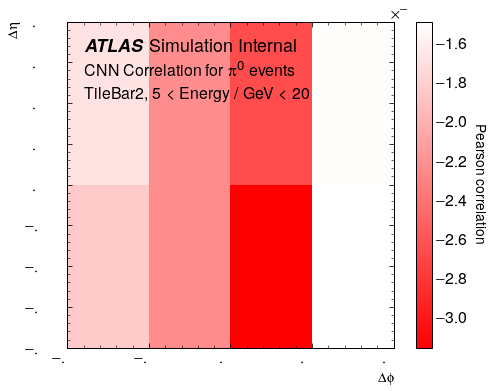

<Figure size 576x432 with 0 Axes>

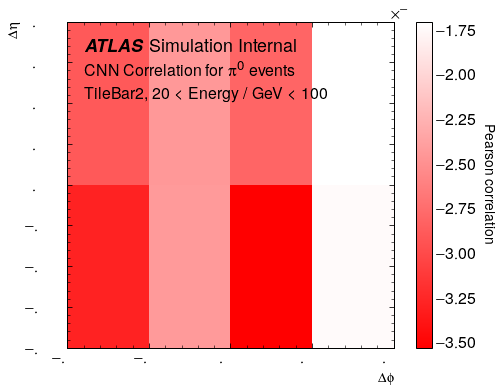

<Figure size 576x432 with 0 Axes>

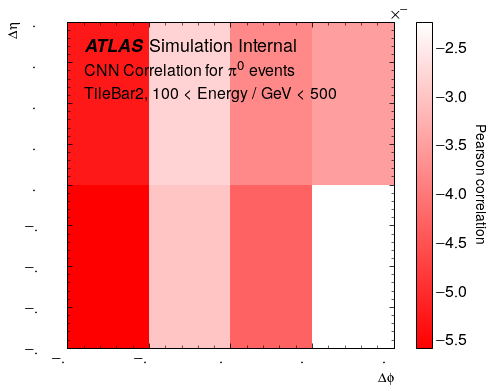

<Figure size 576x432 with 0 Axes>

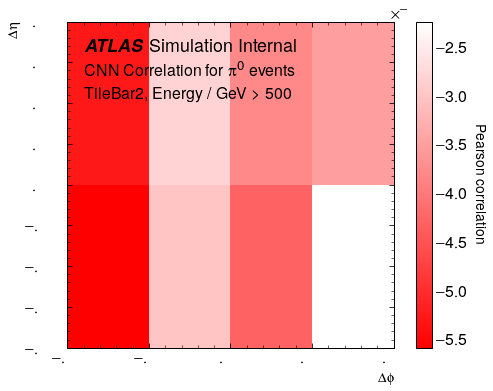

<Figure size 576x432 with 0 Axes>

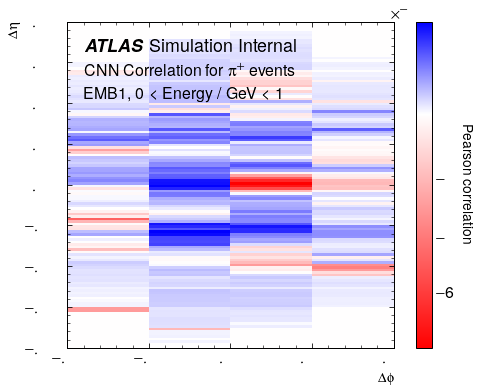

<Figure size 576x432 with 0 Axes>

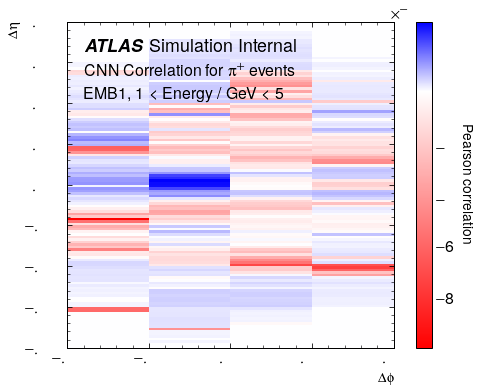

<Figure size 576x432 with 0 Axes>

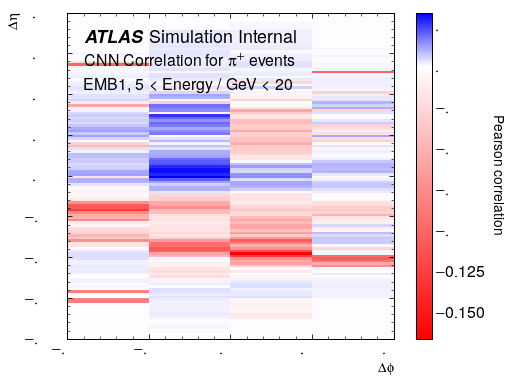

<Figure size 576x432 with 0 Axes>

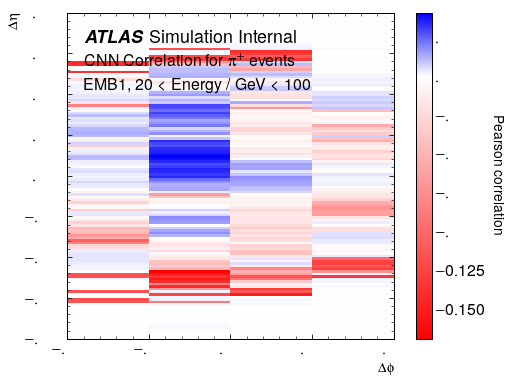

<Figure size 576x432 with 0 Axes>

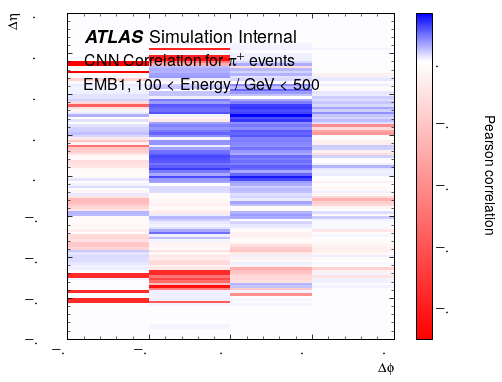

<Figure size 576x432 with 0 Axes>

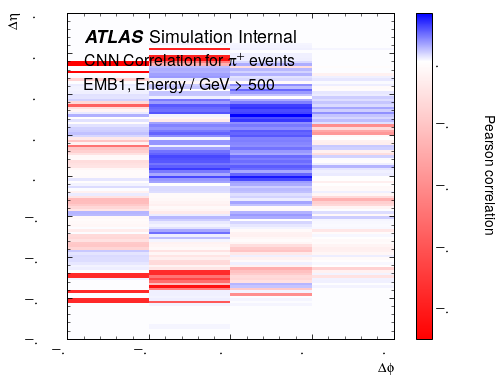

<Figure size 576x432 with 0 Axes>

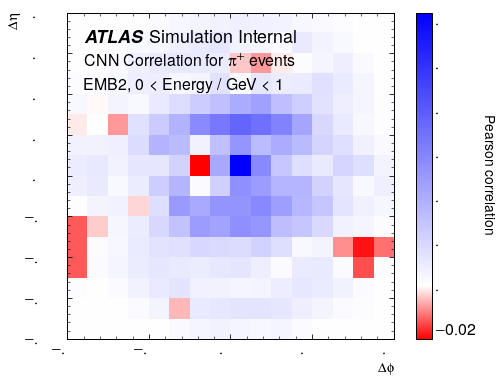

<Figure size 576x432 with 0 Axes>

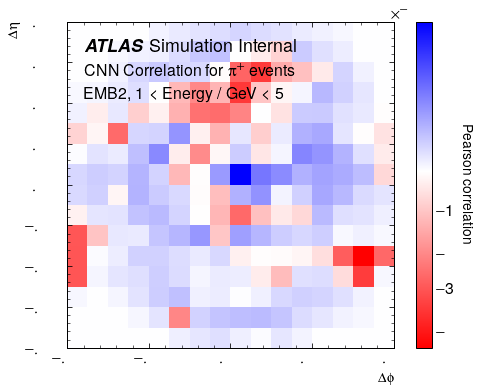

<Figure size 576x432 with 0 Axes>

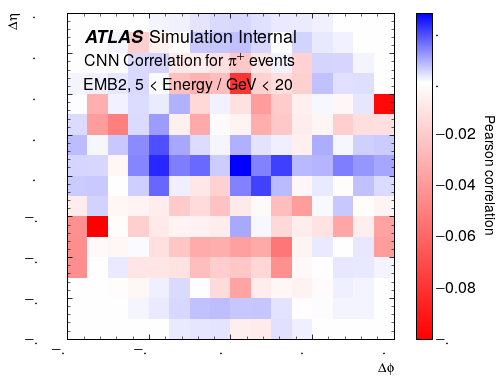

<Figure size 576x432 with 0 Axes>

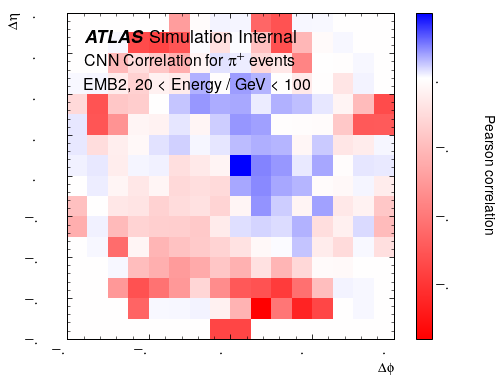

<Figure size 576x432 with 0 Axes>

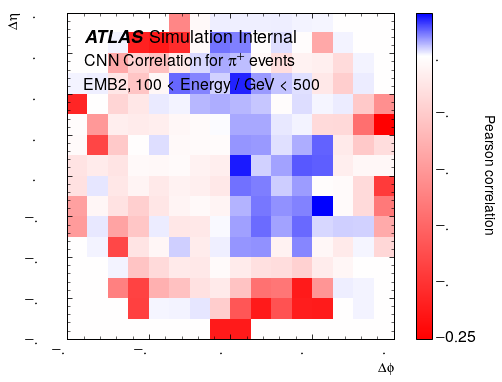

<Figure size 576x432 with 0 Axes>

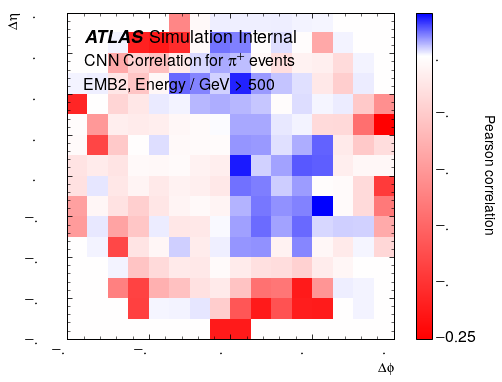

<Figure size 576x432 with 0 Axes>

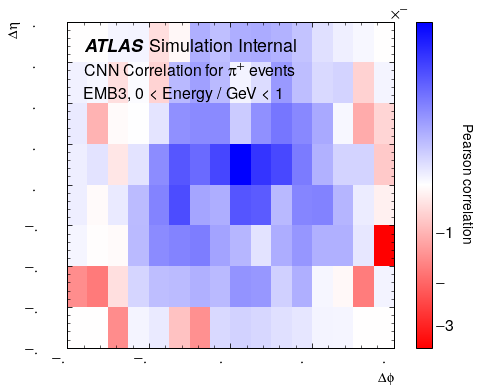

<Figure size 576x432 with 0 Axes>

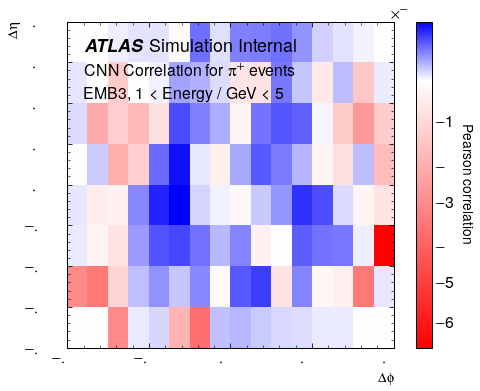

<Figure size 576x432 with 0 Axes>

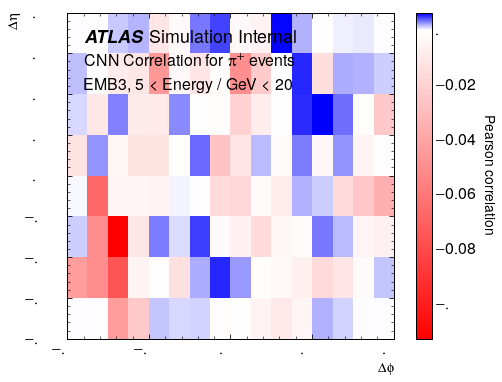

<Figure size 576x432 with 0 Axes>

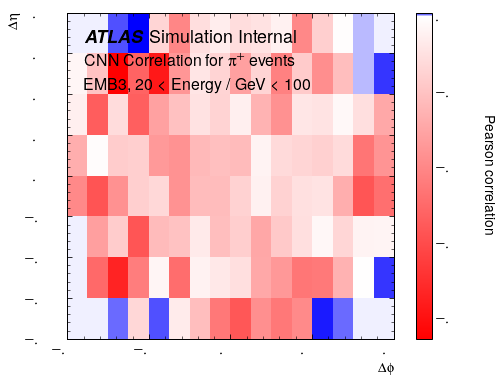

<Figure size 576x432 with 0 Axes>

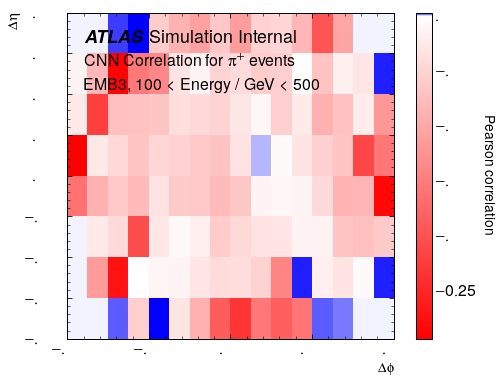

<Figure size 576x432 with 0 Axes>

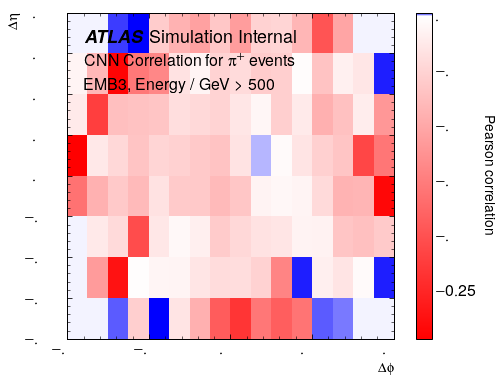

<Figure size 576x432 with 0 Axes>

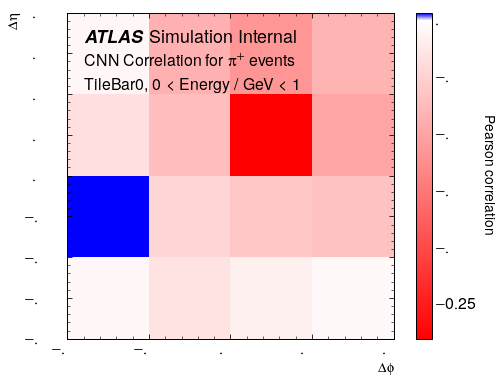

<Figure size 576x432 with 0 Axes>

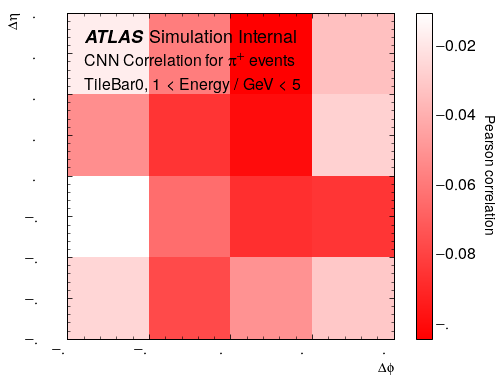

<Figure size 576x432 with 0 Axes>

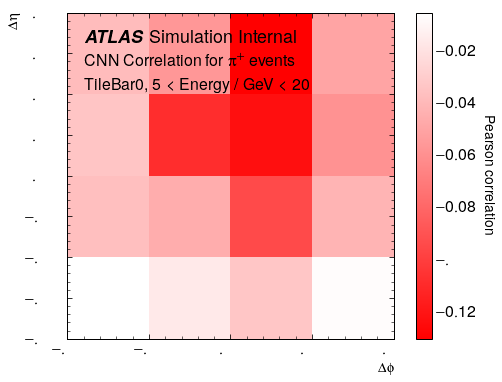

<Figure size 576x432 with 0 Axes>

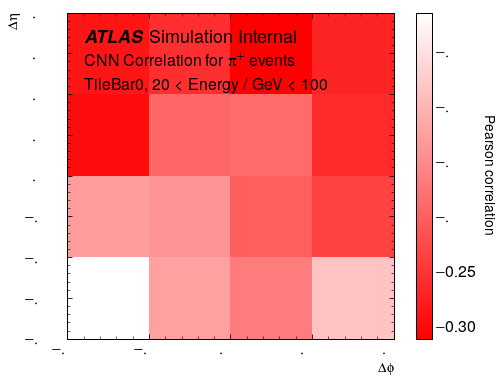

<Figure size 576x432 with 0 Axes>

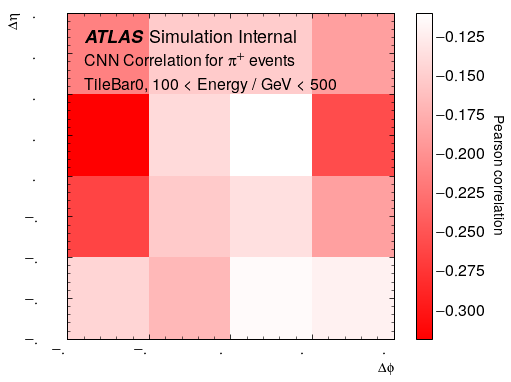

<Figure size 576x432 with 0 Axes>

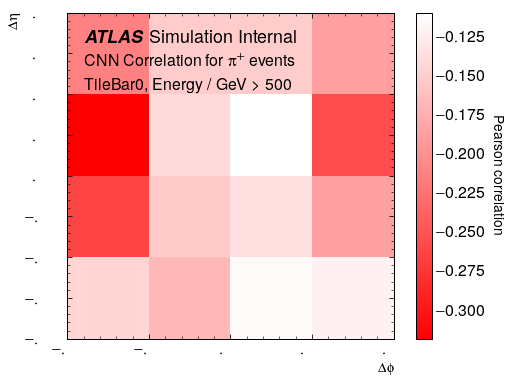

<Figure size 576x432 with 0 Axes>

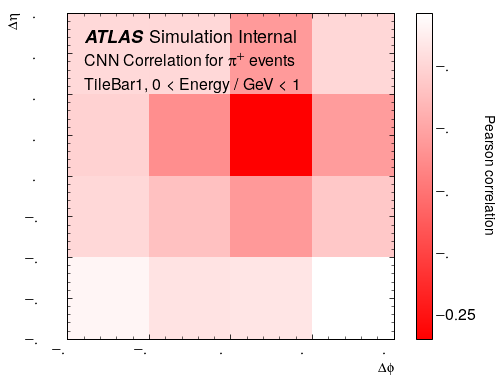

<Figure size 576x432 with 0 Axes>

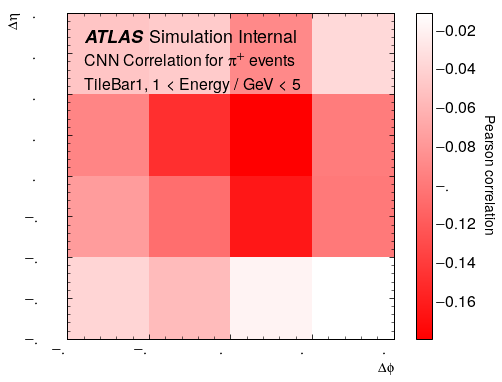

<Figure size 576x432 with 0 Axes>

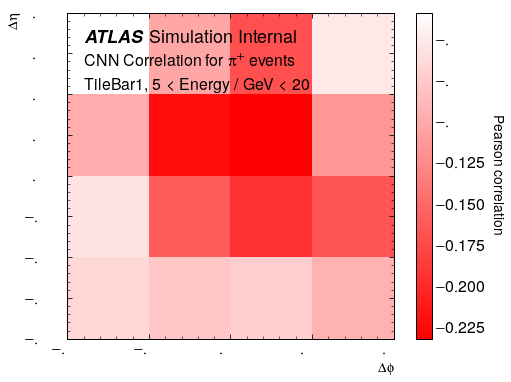

<Figure size 576x432 with 0 Axes>

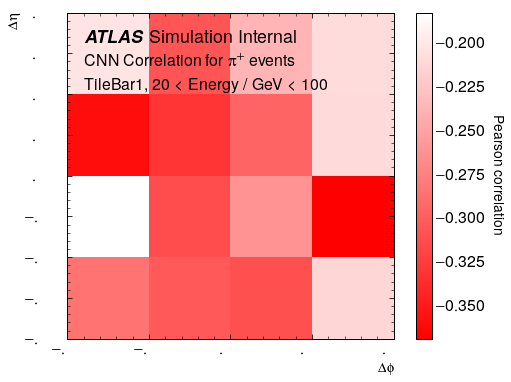

<Figure size 576x432 with 0 Axes>

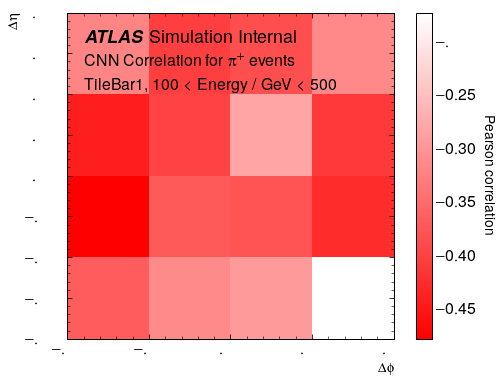

<Figure size 576x432 with 0 Axes>

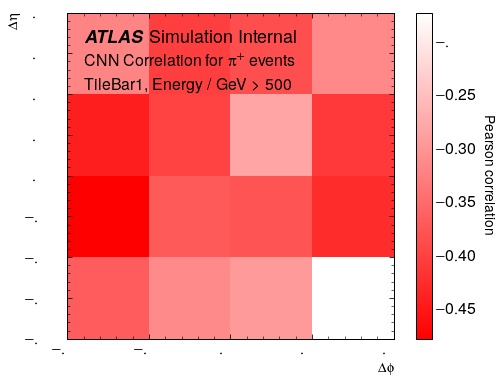

<Figure size 576x432 with 0 Axes>

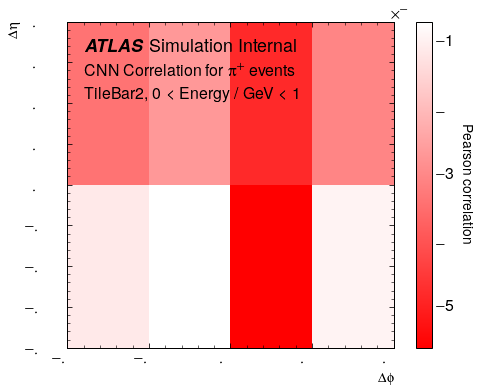

<Figure size 576x432 with 0 Axes>

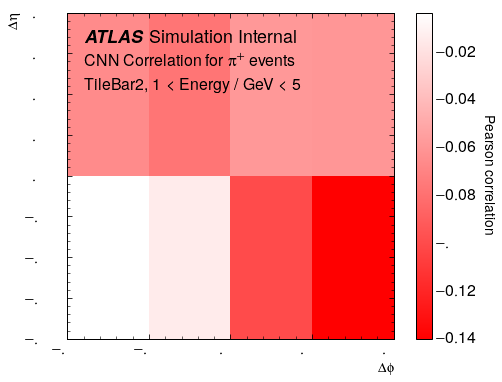

<Figure size 576x432 with 0 Axes>

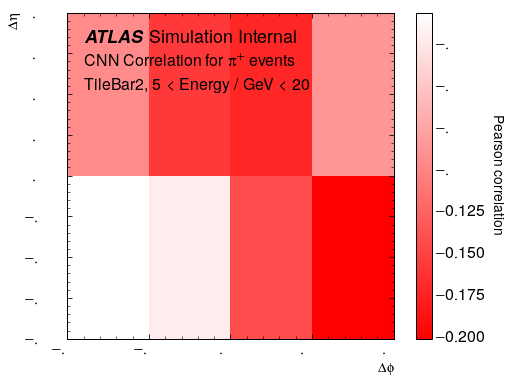

<Figure size 576x432 with 0 Axes>

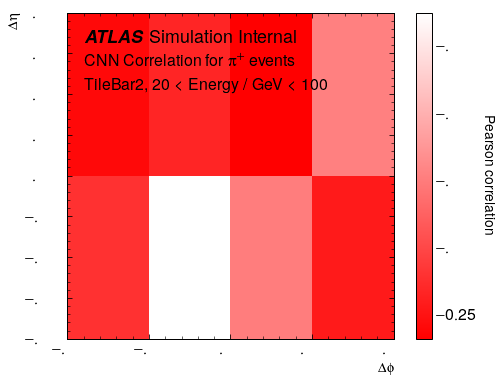

<Figure size 576x432 with 0 Axes>

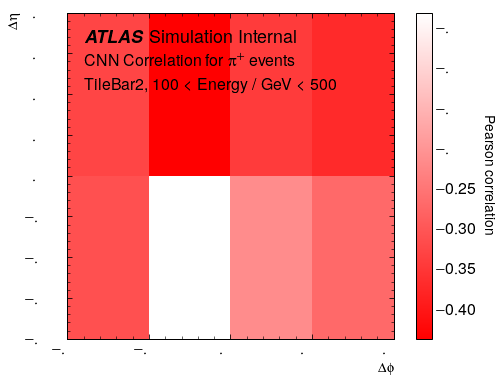

<Figure size 576x432 with 0 Axes>

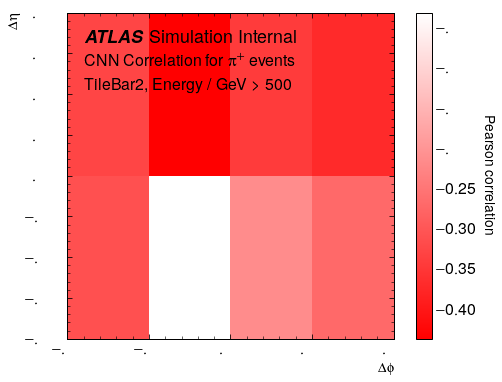

In [81]:
for ptype, pindex in {'pi0':0, 'piplus':1}.items():
    for layer in mu.cell_meta:
        for ibin in range(len(energy_bins)):
            if( ibin == len(energy_bins)-1 ):
                label = 'Energy / GeV > '+str(energy_bins[ibin])
            else:
                label = str(energy_bins[ibin])+' < Energy / GeV < '+str(energy_bins[ibin+1])
            
            plt.cla(); plt.clf()
            fig = plt.figure()
            fig.patch.set_facecolor('white')
            
            data = cor_binned[ptype][layer][ibin][:,:,0]
            data[np.isnan(data)] = 0
            xmin = np.amin(data)
            xmax = np.amax(data)
            plt.imshow(data,
                       extent=[-0.2, 0.2, -0.2, 0.2],
                       cmap=get_cmap(xmin,xmax), origin='lower',
                       interpolation='nearest')
            
            ampl.set_xlabel("$\Delta\phi$")
            ampl.set_ylabel("$\Delta\eta$")
            ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
            fig.axes[0].text(-0.18, 0.135, 'CNN Correlation for '+pi_latex[ptype]+' events')
            fig.axes[0].text(-0.18, 0.105, layer+', '+label)
            cbar = plt.colorbar()
            cbar.set_label('Pearson correlation', rotation=270, labelpad=20)
            plt.savefig(plotpath+'cnncor_binned_'+ptype+'_'+layer+'_clusterE'+str(ibin)+'.pdf')
            plt.show()

In [43]:
for layer in mu.cell_meta:
    print(layer, pcells_merged_reshaped[layer][pdata_merged.test].shape)

EMB1 (139971, 1, 128, 4)
EMB2 (139971, 1, 16, 16)
EMB3 (139971, 1, 8, 16)
TileBar0 (139971, 1, 4, 4)
TileBar1 (139971, 1, 4, 4)
TileBar2 (139971, 1, 2, 4)


In [61]:
pcells_merged_reshaped['EMB1'][pdata_merged.test][(plabels[pdata_merged.test]==0)[:,0]][:,0].shape

(87193, 128, 4)

In [38]:
cnn_scores[(plabels[pdata_merged.test]==0)[:,0]].shape

(87193, 2)

In [63]:
pdata_merged[pdata_merged.test][(plabels[pdata_merged.test]==0)[:,0]]['clusterE']

entry
0         1706.589233
1           58.192909
2            0.349190
4            0.398268
5         1110.176758
             ...     
130779       5.179687
130781      73.476852
130786      46.067532
130787       0.511675
130788      68.169930
Name: clusterE, Length: 87193, dtype: float32